In [5]:
# Feature Engineering - Lin Polar Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

print('OpenCV version: {}'.format(cv2.__version__))

OpenCV version: 3.4.4


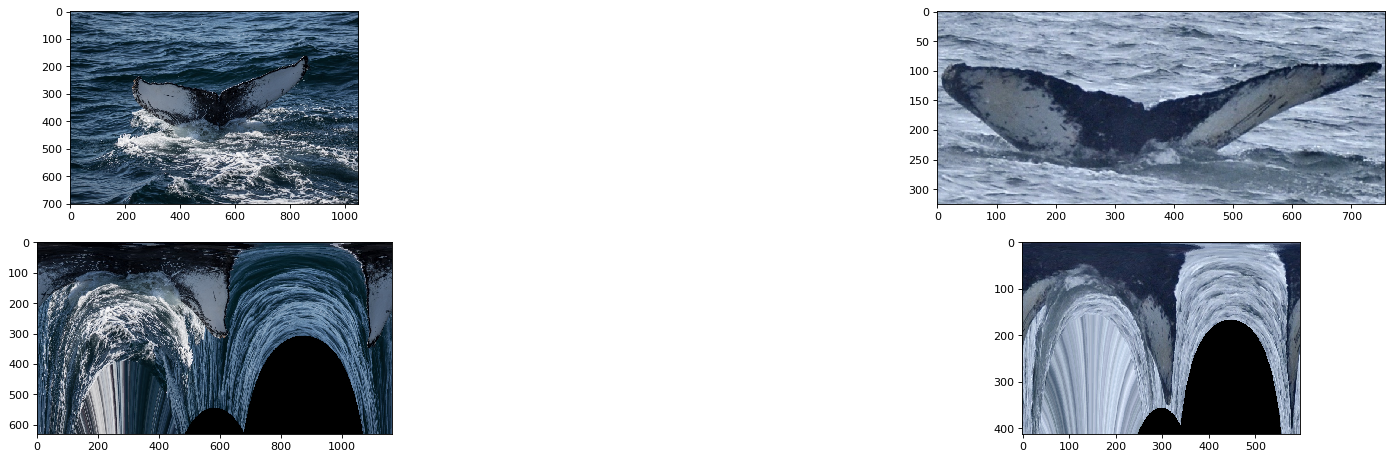

In [6]:
# Read in two different whales
im1 = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/0000e88ab.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
im1_notch = np.array([543, 308])
im2 = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/0001f9222.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
im2_notch = np.array([355, 167])


def pol2cart2D(pol_coord, center):
    x = pol_coord[:, 0] * np.cos(pol_coord[:, 1]) + center[0]
    y = pol_coord[:, 0] * np.sin(pol_coord[:, 1]) + center[1]
    return np.vstack((x, y)).T

def get_quad(image, base_coordinates):
    base_coordinates[0] = max(min(base_coordinates[0], image.shape[1]-1), 0)
    base_coordinates[1] = max(min(base_coordinates[1], image.shape[0]-1), 0)
    try:
        ul = image[base_coordinates[1], base_coordinates[0]]
    except IndexError:
        ul = np.zeros_like(image[0,0,:])
    try:
        ur = image[base_coordinates[1], base_coordinates[0]+1]
    except IndexError:
        ur = ul
    try:
        ll = image[base_coordinates[1]+1, base_coordinates[0]]
    except IndexError:
        ll = ul
    try:
        lr = image[base_coordinates[1]+1, base_coordinates[0]+1]
    except IndexError:
        lr = ul
    return ul, ur, ll, lr


def interpolate2D(image, coordinates):
    assert len(coordinates) >= 2
    coordinates_whole = coordinates.astype(np.uint)
    coordinates_frac = coordinates - coordinates_whole
    ul, ur, ll, lr = get_quad(image, coordinates_whole)
    color = (1-coordinates_frac[0])*(1-coordinates_frac[1])*ul.astype(np.float) + \
            (coordinates_frac[0])*(1-coordinates_frac[1])*ur.astype(np.float) + \
            (1-coordinates_frac[0])*(coordinates_frac[1])*ll.astype(np.float) + \
            (coordinates_frac[0])*(coordinates_frac[1])*lr.astype(np.float)
    return (color + 0.5).astype(np.uint)


# Convert images to polar images at centerpoint
def cart_to_polar_image(cart_image, center):
    try:
        channels = cart_image.shape[2]
    except:
        channels = 1
    # Inverse transform polar mesh grid into cartesian coordinates
    image_R = np.sqrt((cart_image.shape[0] / 2) ** 2 + (cart_image.shape[1] / 2) ** 2)
    # Step radius by 1px in the longest dimension
    image_dr = 1  # aligned to pixel pitch, so our sampling is undistorted along a cartesian axis
    image_r = np.arange(image_R / image_dr)
    # Try not to change the total number of pixels in the image
    image_nphi = cart_image.shape[0] * cart_image.shape[1] / image_r.shape[0]
    image_dphi = 2 * np.pi / image_nphi
    image_phi = np.arange(0, 2 * np.pi, image_dphi)
    pol_image_shape = (image_r.shape[0], image_phi.shape[0], channels)
    pol_image = np.empty(pol_image_shape)
    pol_image = pol_image.astype(cart_image.dtype)

    image_r_mesh, image_theta_mesh = np.meshgrid(image_r, image_phi)
    image_r_phi = np.dstack((image_r_mesh, image_theta_mesh))
    image_r_phi_in_cart = np.reshape(
        pol2cart2D(np.reshape(image_r_phi, (np.multiply(*image_r_phi.shape[0:2]), image_r_phi.shape[2])), center),
        image_r_phi.shape
    )
    image_r_phi_serial = np.reshape(image_r_phi, (np.multiply(*image_r_phi.shape[0:2]), image_r_phi.shape[2])) / np.array((image_dr, image_dphi))
    image_r_phi_in_cart_serial = np.reshape(image_r_phi_in_cart, (np.multiply(*image_r_phi_in_cart.shape[0:2]), image_r_phi_in_cart.shape[2]))
    # Bilinearly interpolate image into polar image
    for polar, cart in zip(image_r_phi_serial, image_r_phi_in_cart_serial):
        # Bilinearly interpolate the cartesian image
        pol_image[int(polar[0]+0.5), int(polar[1]+0.5), :] = interpolate2D(cart_image, cart)

    return pol_image


im1_polar = cart_to_polar_image(im1, im1_notch)
im2_polar = cart_to_polar_image(im2, im2_notch)

f = plt.figure(
    num=1,
    figsize=(28, int(28*1/float(4))),
    dpi=80,
    facecolor='w',
    edgecolor='k'
)
plt.subplot(2,2,1)
f.gca().grid(False)
plt.imshow(im1)
plt.subplot(2,2,2)
f.gca().grid(False)
plt.imshow(im2)
plt.subplot(2,2,3)
f.gca().grid(False)
plt.imshow(im1_polar)
plt.subplot(2,2,4)
f.gca().grid(False)
plt.imshow(im2_polar)
plt.show()

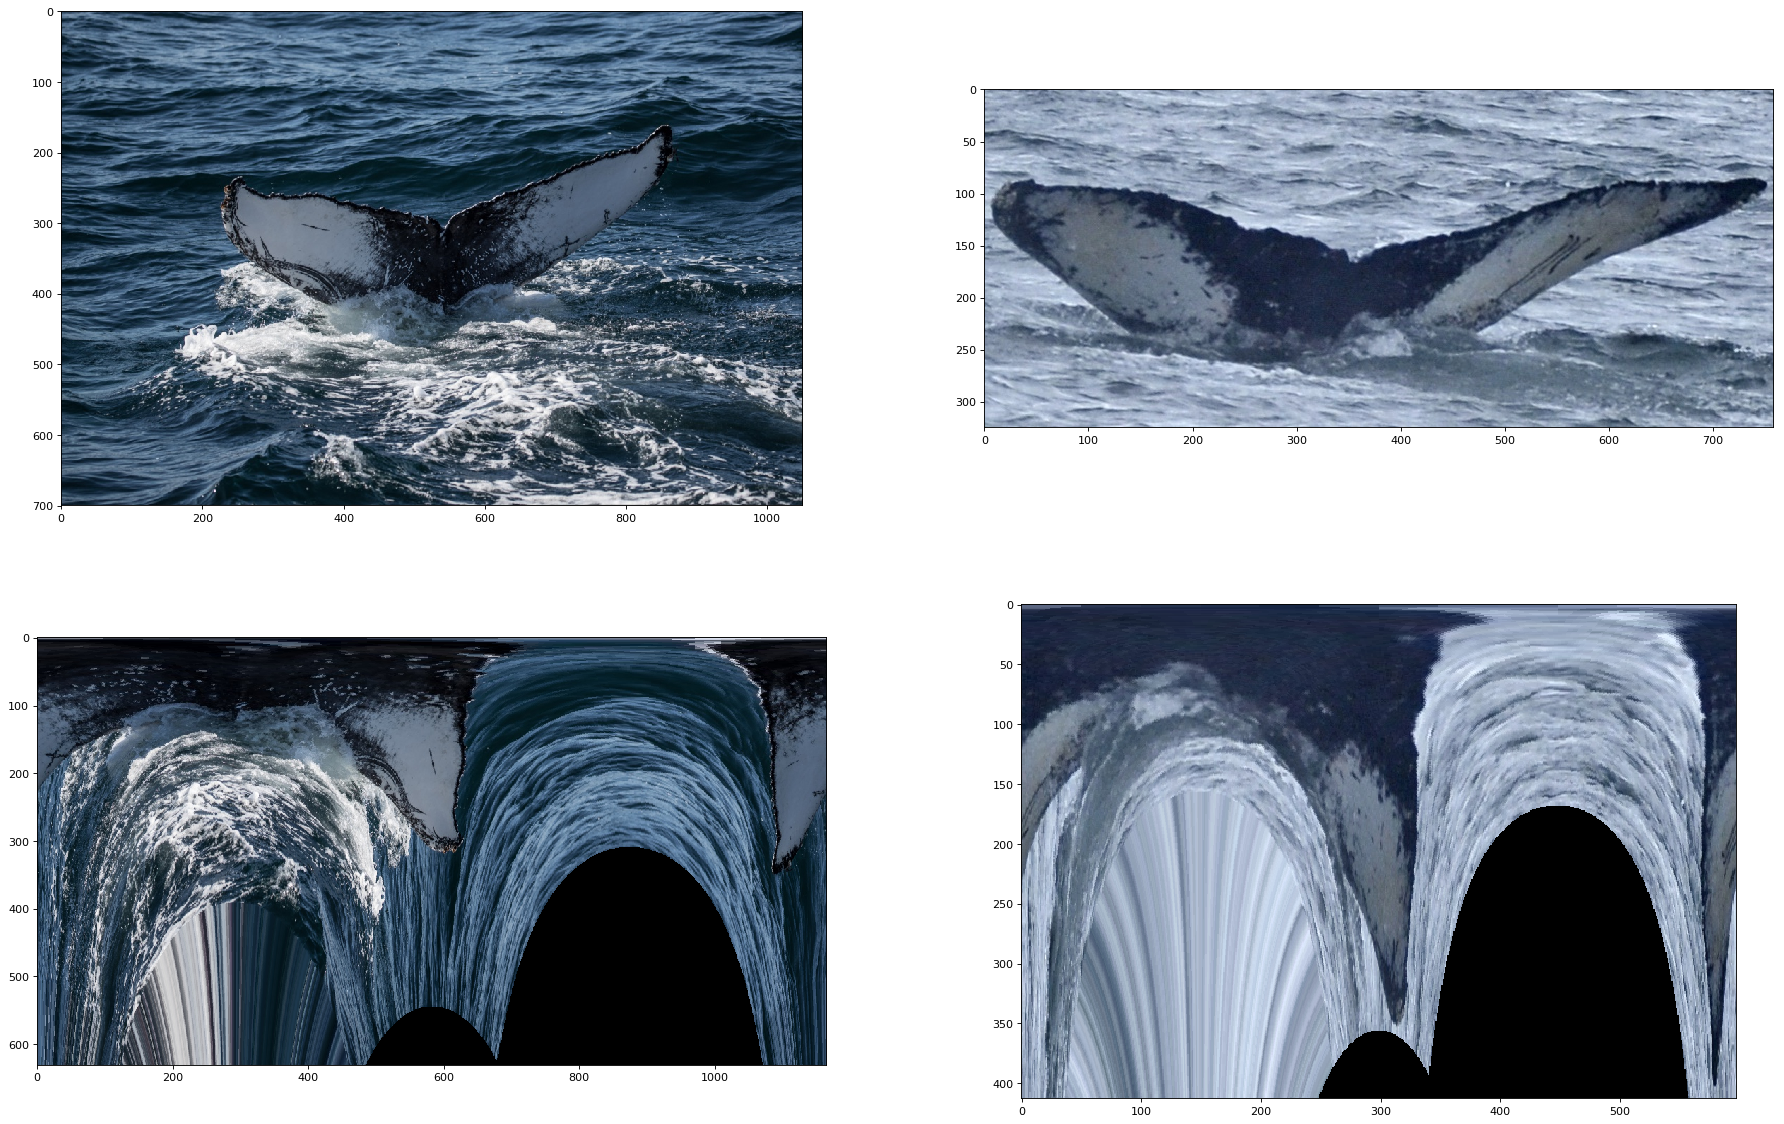

In [7]:
f = plt.figure(
    num=1,
    figsize=(28,18),
    dpi=80,
    facecolor='w',
    edgecolor='k'
)
plt.subplot(2,2,1)
f.gca().grid(False)
plt.imshow(im1)
plt.subplot(2,2,2)
f.gca().grid(False)
plt.imshow(im2)
plt.subplot(2,2,3)
f.gca().grid(False)
plt.imshow(im1_polar)
plt.subplot(2,2,4)
f.gca().grid(False)
plt.imshow(im2_polar)
plt.show()

In [ ]:
# Train network on 